In [1]:
# import...

import xarray as xr
import os
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
from geopy import distance
import warnings
import scipy.stats as stats

os.chdir("/Users/etmu9498/research/code/scripts")
import helper_fns
import make_plots

os.chdir("/Users/etmu9498/research/code/scripts/boundary-layer")
import boundary_layer_scripts

In [2]:
# find z_i, the thermodynamic mixed layer depth, using zhang's definition:
# z_i = the height where theta_v increases by .5 k from the mean value of data from the lowest 150m
def crl_findzi( z, thetav):
        
    # trim heights and temps to values under 150 m!
    z150 = z[ np.where( z <= 150.0 )]
    thetav150 = thetav[ np.where( z <= 150.0 )]

    # find the mean virt pot temp value below 150m
    mean_thetav = np.nanmean( thetav150)
    
    # search through thetas above 150m for values more than .5 K > mean theta
    # the first one found ( lowest one) is the mixed layer height!
    thetav_above150 = thetav[ np.where( z > 150.0 )]
    z_above150 = z[ np.where( z > 150.0 )]

    # reverse matrices to cycle through lowest values first
    thetav_above150 = np.flip( thetav_above150)
    z_above150 = np.flip( z_above150)
    
    # iterate through values
    for i in range( len( thetav_above150)):
     
        # check if value passes the temperature threshold!
        # return case
        if thetav_above150[i] >= mean_thetav + .5:
            theta_i = thetav_above150[i]
            z_i = z_above150[i]
            return theta_i, z_i
        

In [3]:
# find z_i, the thermodynamic mixed layer depth, using zhang's definition:
# z_i = the height where theta_v increases by .5 k from the mean value of data from the lowest 150m
def findzi( z, thetav):
        
    # trim heights and temps to values under 150 m!
    z150 = z[ np.where( z.magnitude <= 150.0 )]
    thetav150 = thetav[ np.where( z.magnitude <= 150.0 )]

    # find the mean virt pot temp value below 150m
    mean_thetav = np.nanmean( thetav150)

    # check if min height is above 150m... if so, z150 will be empty and we can't calculate an avg bl temp :(
    # return Nan values to avoid plotting errors
    if len( z150) == 0:
        return np.nan
    
    # case where too little data is saved in file :(
    if len( thetav) < 50:
        return np.nan
    
    # search through thetas above 150m for values more than .5 K > mean theta
    # the first one found ( lowest one) is the mixed layer height!
    thetav_above150 = thetav[ np.where( z.magnitude > 150.0 )]
    z_above150 = z[ np.where( z.magnitude > 150.0 )]

    # reverse matrices to cycle through lowest values first
    thetav_above150 = np.flip( thetav_above150)
    z_above150 = np.flip( z_above150)
    
    # iterate through values
    for i in range( len( thetav_above150)):
     
        # check if value passes the temperature threshold!
        # return case
        if thetav_above150[i].magnitude >= mean_thetav.magnitude + .5:
            
            threshold = mean_thetav.magnitude + .5
            theta_i = thetav_above150[i]
            z_i = z_above150[i]
            return z_i.magnitude
 

In [4]:
# find vmax, the maximum total wind speed in a profile!
# use optional var to choose max height limit for looking at vars
# inputs: height array z and wind speed array v. Optional: maxh; float in meters
def findvmax( z, v, maxh=False):

#     print( v)
#     print( z)
#     print( len( z))
    
    # case where manually setting a max height to look up to
    if maxh:
        inds = np.where( z.magnitude <= maxh)
        z = z[ inds]
        v = v[ inds]
        
    # find the max wind speed height!
    i_maxv = np.nanargmax( v.magnitude)
    return z[ i_maxv].magnitude

In [5]:
# calculate and return the bulk richardson number for a profile, and find its associated boundary layer height! 

def find_ri_bulk( theta, z, u, v, window=False):

    # initialize constants and an empty array to hold eventual bulk richardson number calculations
    g = 9.81
    ri_bulk = []
    
    '''
    print( len( theta))
    print( len( z))
    print( len( u))
    print( len( v))
    '''
    
    # remember that index 0 corresponds to the highest height!
    # so z[ i] - z[ i+1] is a positive number
    # the -1 accounts for iterative overflow; without it, i+1 would access too high of an index
    for i in range( len( theta) -1):
    
        delta_theta = theta[ i] - theta[ i+1]
        delta_z = z[ i] - z[ i+1]
        mean_theta = .5 * ( theta[ i] + theta[ i+1])
        delta_u2 = ( u[i] - u[i+1] )**2
        delta_v2 = ( v[i] - v[i+1] )**2

        ri_bulk_i = g * (delta_theta) * (delta_z) / ((mean_theta)*(delta_u2 + delta_v2))
    
        ri_bulk.append( ri_bulk_i.magnitude)
    
    return ri_bulk

def find_ri_bulk_cutoff( theta, z, u, v):
    
    # get all the bulk richardson numbers
    ri_bulk = find_ri_bulk( theta, z, u, v)
    
    # reverse matrices to cycle through lowest values first
    ri_bulk = np.flip( ri_bulk)
    z = np.flip( z)
    
    # iterate through values
    for i in range( len( z)):
     
        # check if value passes the richardson number threshold!
        # return case
        if ri_bulk[i] >= .25:
            return z[ i].magnitude

In [6]:
# calculate the mixed layer height, max velocity height, and bulk richardson number cutoff for all soundings!
# also, find their distances from the TC center for comparisons

# repeat steps above for all sondes shown in fig 1 (goes image)! 
sounding_directory = "/Users/etmu9498/research/data/dropsondes/bl-final-project/"
sounding_list = make_plots.load_sondes( sounding_directory, print_files=False)

# defining constants
tc_center = (20.375, -57.85)

# fill these lists through iteration
x = [] # distance from TC center
ri_bulk = [] # bulk richardson number
z_i = [] # mixed layer height
hvmax = [] # height of the maximum total velocity
hvmax_hlim = [] # height of the maximum total velocity: height limited to lowest 2000m


# repeat these steps for all soundings
for i in range( len( sounding_list)): # 21, 27): # 14):    
    sounding_filename = sounding_list[ i]
    col_names = [ 'IX', 't (s)', 'P (mb)', 'T (C)', 'RH (%)', 'Z (m)', 'WD', 'WS (m/s)', 'U (m/s)', 'V (m/s)', 'NS', 
                  'WZ (m/s)', 'ZW (m)', 'FP', 'FT', 'FH', 'FW', 'LAT (N)', 'LON (E)' ]

    df = pd.read_fwf(sounding_directory+sounding_filename, 
                     skiprows=21, names=col_names) # usecols=[1, 2, 3, 4, 5, 6, 7, 8, 14],
    # trying to get rid of duplicate index, but not having any success
    df.reset_index(drop=True, inplace=True)

    # replace fill values with nans!
    df['P (mb)'].replace(-999.0, np.nan,inplace=True)
    df['T (C)'].replace(-999.00, np.nan,inplace=True)
    df['RH (%)'].replace(-999.0, np.nan,inplace=True)
    df['Z (m)'].replace(-999, np.nan,inplace=True)
    df['WD'].replace(-999, np.nan,inplace=True)

    df['WS (m/s)'].replace(-999.00, np.nan,inplace=True)
    df['U (m/s)'].replace(-999.00, np.nan,inplace=True)
    df['V (m/s)'].replace(-999.00, np.nan,inplace=True)
    df['WZ (m/s)'].replace(-999.0, np.nan,inplace=True)
    df['ZW (m)'].replace(-999, np.nan,inplace=True)
    df['WD'].replace(-999, np.nan,inplace=True)
    df['LAT (N)'].replace(-999.000, np.nan,inplace=True)
    df['LON (E)'].replace(-999.000, np.nan,inplace=True)

    # remove nans for plotting purposes
    df = df.dropna(subset=('P (mb)', 'T (C)', 'RH (%)', 'Z (m)', 'WD', 'WS (m/s)'), how='any').reset_index(drop=True)

    # rename variables into more convenient forms and calculate a couple other variables
    T = df['T (C)'].values * units.degC
    z = df['Z (m)'].values * units.m
    p = df['P (mb)'].values * units.hPa
    wind_speed = df['WS (m/s)'].values * units.mps
    wind_dir = df['WD'].values * units.degrees
    RH = df['RH (%)'].values

    theta = mpcalc.potential_temperature(p, T)   # This metpy routine calculates theta and gives it units of Kelvin
    mixing_ratio = mpcalc.mixing_ratio_from_relative_humidity(p, T, RH / 100) # This metpy routine calculates mixing ratio
    theta_v = mpcalc.virtual_potential_temperature(p, T, mixing_ratio) # metpy to calculate theta_V
    dewpoint = mpcalc.dewpoint_from_relative_humidity(T, RH)
    theta_e = mpcalc.equivalent_potential_temperature(p, T, dewpoint)

    hours = sounding_filename[ 10:12]
    mins = sounding_filename[ 12:14]
    secs = sounding_filename[ 14:16]
    time = float( hours) + float( mins) / 60 + float( secs) / 3600


    ############ calculate important quantities!! ############
    
    # calculate z_i and plot it on the profile!
    z_i.append( findzi( z, theta_v))
    
    # find the max wind speed height: no filter
    hvmax.append( findvmax( z, wind_speed))
    # find the max wind speed height: 2000m max filter
    hvmax_hlim.append( findvmax( z, wind_speed, maxh=2000.0))

    # find the bulk richardson number
    ri_bulk.append( find_ri_bulk_cutoff( theta, z, df['U (m/s)'], df['V (m/s)']))
    
    
    # find distance from tc center for each sounding
    # rename lat and lon variables
    lat = df['LAT (N)'].values * units.degrees_north
    lon = df['LON (E)'].values * units.degrees_east
    
    # use the first lat and lon values, as these are closest to the plane's orig location!
    sonde_loc = ( lat[0].magnitude, lon[0].magnitude)

    # calculate the distance from the tc center using geopy!
    x.append( distance.distance( sonde_loc, tc_center).km )


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\pint\quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\pint\quantity.py:1313: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\pint\quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent
C:

C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\pint\quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\pint\quantity.py:1313: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\pint\quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent
C:

In [7]:
# plot crl and dropsonde mixed layer heights on the same plot!!
# code taken from "lidar mixed layer height scripts"

# load crl data and find crl theta and thetav
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path, print_files=False)
crl_name = crl_list[ 18]
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)

newh, crl_theta, crl_thetav = boundary_layer_scripts.find_theta_thetav( tcname='sam', dataset=5)

print( np.shape( crl_theta))

tc_center = (20.375, -57.85)


# fill these lists through iteration
zi_times = []
crlx = [] # distance from TC center
crlzi = [] # mixed layer height

# iterate through all the thousands of crl profiles! look for ones reaching the bottom 150m of the boundary layer
for i in range( len( crl_data.time)):
    
    z = - newh * 1000
    thetav = crl_thetav[ i, :]
    
    # trim temps to values under 150 m! are there values?
    thetav150 = thetav[ np.where( z <= 25.0 )]
    thetav150 = thetav150[ np.where( ~ np.isnan( thetav150))]
    
    # print( thetav150)
    
    
    # there's data below 150 m case! 
    if len( thetav150) > 0:
        
        theta_i, zind = crl_findzi( z, thetav)

        crlzi.append( round( zind, 4))
        
        # find distances for this case!
        # rename lat and lon variables
        lat = crl_data.Lat[i].values
        lon = crl_data.Lon[i].values

        # use the first lat and lon values, as these are closest to the plane's orig location!
        sonde_loc = ( lat, lon)

        # calculate the distance from the tc center using geopy!
        dist = distance.distance( sonde_loc, tc_center).km
        crlx.append( round( dist, 4))

        # save the times of each valid point
        zi_times.append( float( crl_data.time[ i].values))
        
        
        
    if i % 500 == 0:
        print("case " + str(i) + " completed")
        
        

correcting crl heights
temperature interpolated
water vapor interpolated
creating pressure matrix
(9300, 667)
case 0 completed
case 500 completed
case 1000 completed
case 1500 completed
case 2000 completed
case 2500 completed
case 3000 completed
case 3500 completed
case 4000 completed
case 4500 completed
case 5000 completed
case 5500 completed
case 6000 completed
case 6500 completed
case 7000 completed
case 7500 completed
case 8000 completed
case 8500 completed
case 9000 completed


Subplot 1 R^2 = 0.019738750580159836
2.1404556698879915
164.41041899815275


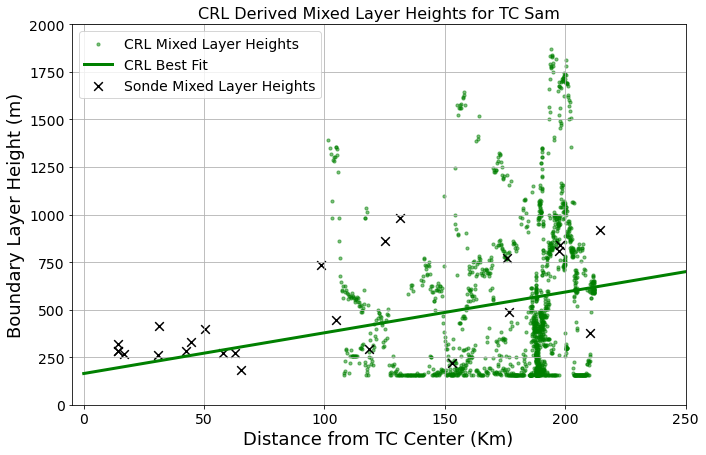

In [23]:
# make plot
plt.figure( figsize=(11, 7))

helper_fns.change_font_sizes()
plt.xlabel( "Distance from TC Center (Km)")
plt.ylabel( "Boundary Layer Height (m)")
plt.grid('on')
plt.title( "CRL Derived Mixed Layer Heights for TC Sam", fontsize=16)
plt.scatter( crlx, crlzi, c='g', s=10, label='CRL Mixed Layer Heights', alpha=.5)


# best fit for plot 1
slope, intercept, r, p, se = stats.linregress(  crlx, crlzi)
best_fit_x = np.linspace( 0, 500, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='g', linewidth=3, label='CRL Best Fit')

plt.xlim( [-5, 250])
plt.ylim( [0, 2000])

print("Subplot 1 R^2 = " + str( r**2))
print( slope)
print( intercept)


# plot dropsonde data on top
plt.scatter( x, z_i, c='k', s=75, marker='x', label='Sonde Mixed Layer Heights')

plt.legend()


Subplot 1 slope = 2.415685241935763
Subplot 1 y int = 235.50758937464457
Subplot 1 R^2 = 0.4274613943803866
Subplot 2 slope = 3.9465830434566747
Subplot 2 y int = 510.7305925854157
Subplot 2 R^2 = 0.20835005426686726
Subplot 3 slope = -1.2494274441760496
Subplot 3 y int = 365.7520516483233
Subplot 3 R^2 = 0.19198045240704484
Subplot 4 slope = 8.954558305132151
Subplot 4 y int = 383.43261679266016
Subplot 4 R^2 = 0.4193680463090058


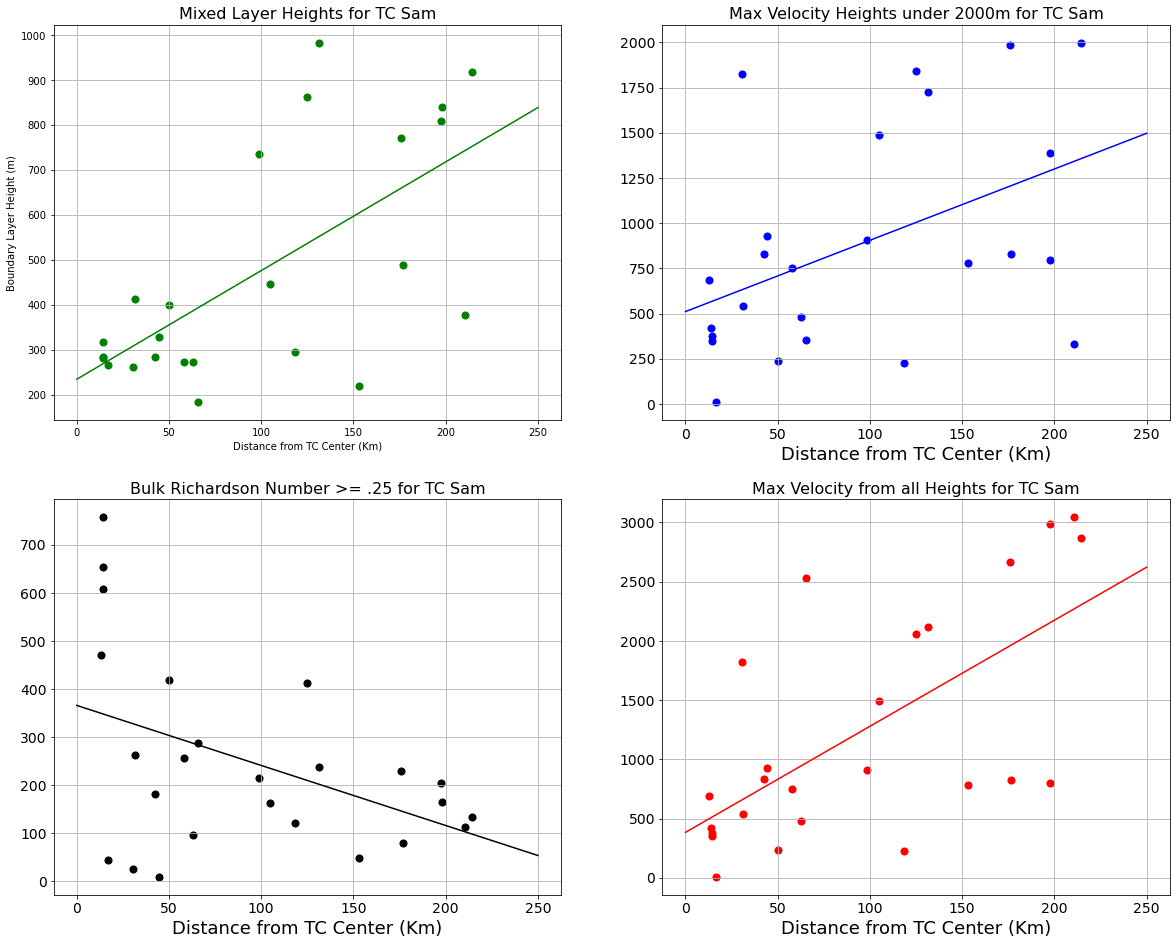

In [6]:
# make a plot similar to zhang's conceptual plot!
# and add fit lines to the three scatter plots!


# setup: mask nan values for line fitting
mask0 = ~np.isnan(x) & ~np.isnan(z_i)
mask1 = ~np.isnan(x) & ~np.isnan(hvmax_hlim)
mask2 = ~np.isnan(x) & ~np.isnan(ri_bulk)

# convert to arrays for proper indexing
x = np.array( x)
z_i = np.array( z_i)
hvmax_hlim = np.array( hvmax_hlim)
ri_bulk = np.array( ri_bulk)

plt.figure( figsize=(20, 16))

plt.subplot( 221)
helper_fns.change_font_sizes()
plt.xlabel( "Distance from TC Center (Km)")
plt.ylabel( "Boundary Layer Height (m)")
plt.grid('on')
plt.title( "Mixed Layer Heights for TC Sam", fontsize=16)
plt.scatter( x, z_i, c='g', s=50, label='Mixed Layer Height')

# best fit for plot 1
slope, intercept, r, p, se = stats.linregress(  x[mask0], z_i[mask0])
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='g', label='Best fit')

print("Subplot 1 slope = " + str( slope))
print("Subplot 1 y int = " + str( intercept))
print("Subplot 1 R^2 = " + str( r**2))

plt.subplot( 222)
helper_fns.change_font_sizes()
plt.xlabel( "Distance from TC Center (Km)")
plt.grid('on')
plt.title( "Max Velocity Heights under 2000m for TC Sam", fontsize=16)
plt.scatter( x, hvmax_hlim, c='b', s=50, label='Height of vmax below 2000 m')

# best fit for plot 2
slope, intercept, r, p, se = stats.linregress( x, hvmax_hlim)
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='b', label='Best fit')

print("Subplot 2 slope = " + str( slope))
print("Subplot 2 y int = " + str( intercept))
print("Subplot 2 R^2 = " + str( r**2))

plt.subplot( 223)
helper_fns.change_font_sizes()
plt.xlabel( "Distance from TC Center (Km)")
plt.grid('on')
plt.title( "Bulk Richardson Number >= .25 for TC Sam", fontsize=16)
plt.scatter( x, ri_bulk, c='k', s=50, label='Height where Ri >=.25')

# best fit for plot 3
slope, intercept, r, p, se = stats.linregress( x, ri_bulk)
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='k', label='Best fit')

print("Subplot 3 slope = " + str( slope))
print("Subplot 3 y int = " + str( intercept))
print("Subplot 3 R^2 = " + str( r**2))

plt.subplot( 224)
helper_fns.change_font_sizes()
plt.xlabel( "Distance from TC Center (Km)")
plt.grid('on')
plt.title( "Max Velocity from all Heights for TC Sam", fontsize=16)
plt.scatter( x, hvmax, c='r', s=50, label='Height of vmax below 2000 m')

# best fit for plot 4
slope, intercept, r, p, se = stats.linregress( x, hvmax)
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='r', label='Best fit')

print("Subplot 4 slope = " + str( slope))
print("Subplot 4 y int = " + str( intercept))
print("Subplot 4 R^2 = " + str( r**2))

# print( len( x))
# print( len( z_i))
# print( len( hvmax))
# print( len( ri_bulk))

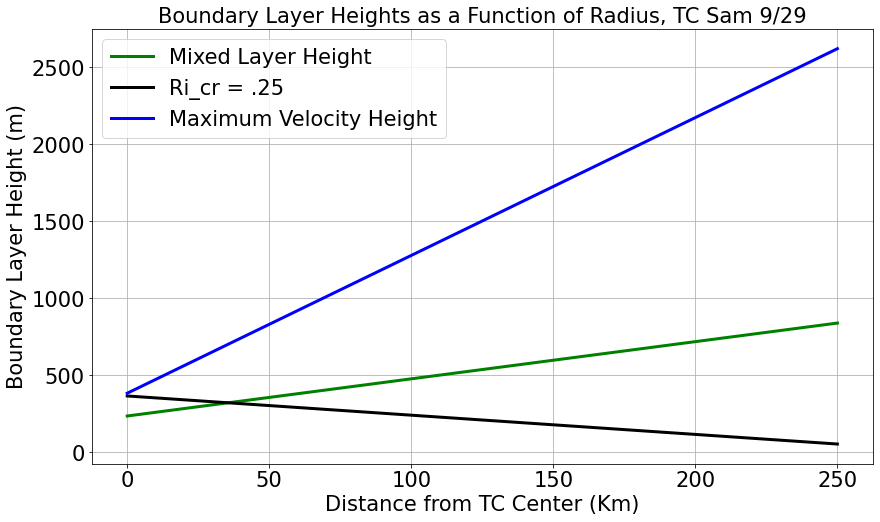

In [10]:
# make a plot similar to zhang's conceptual plot!
# and add fit lines to the three scatter plots!


# setup: mask nan values for line fitting
mask0 = ~np.isnan(x) & ~np.isnan(z_i)
mask1 = ~np.isnan(x) & ~np.isnan(hvmax_hlim)
mask2 = ~np.isnan(x) & ~np.isnan(ri_bulk)

# convert to arrays for proper indexing
x = np.array( x)
z_i = np.array( z_i)
hvmax_hlim = np.array( hvmax_hlim)
ri_bulk = np.array( ri_bulk)

plt.figure( figsize=(14, 8))

fsize=21
helper_fns.change_font_sizes(small=fsize, medium=fsize)
plt.xlabel( "Distance from TC Center (Km)")
plt.ylabel( "Boundary Layer Height (m)")
plt.grid('on')

w = 3

# best fit for plot 1
slope, intercept, r, p, se = stats.linregress(  x[mask0], z_i[mask0])
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='g', label="Mixed Layer Height", linewidth=w)


slope, intercept, r, p, se = stats.linregress( x, ri_bulk)
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='k', label='Ri_cr = .25', linewidth=w)


# best fit for plot 4
slope, intercept, r, p, se = stats.linregress( x, hvmax)
best_fit_x = np.linspace( 0, 250, 500)
best_fit_y = slope * best_fit_x + intercept
plt.plot( best_fit_x, best_fit_y, c='b', label='Maximum Velocity Height', linewidth=w)

plt.title("Boundary Layer Heights as a Function of Radius, TC Sam 9/29")

plt.legend()
